# More complex call graph example with llvmlite:
- direct calls
- extern calls
- recursion & mutual recursion
- indirect calls via function pointers
- simple resolution from a global function table

Output: adjacency + DOT + edge call counts

In [1]:
from llvmlite import ir
from collections import defaultdict, Counter

In [2]:
# Build a more complex module

m = ir.Module(name="cg_complex")
i32 = ir.IntType(32)
i8  = ir.IntType(8)
i8p = i8.as_pointer()

# extern int puts(char*);
puts = ir.Function(m, ir.FunctionType(i32, [i8p]), name="puts")

# helper to create a global string constant
def add_global_cstr(module, name, s: bytes):
    arr_ty = ir.ArrayType(i8, len(s))
    gv = ir.GlobalVariable(module, arr_ty, name=name)
    gv.linkage = "internal"
    gv.global_constant = True
    gv.initializer = ir.Constant(arr_ty, bytearray(s))
    gv.align = 1
    # i8* pointer to first element
    zero = ir.Constant(i32, 0)
    return gv.gep((zero, zero))

msg_even = add_global_cstr(m, "msg_even", b"even\0")
msg_odd  = add_global_cstr(m, "msg_odd",  b"odd\0")

# int leafA(int x) { return x + 7; }
leafA = ir.Function(m, ir.FunctionType(i32, [i32]), name="leafA")
x = leafA.args[0]
b = ir.IRBuilder(leafA.append_basic_block("entry"))
b.ret(b.add(x, ir.Constant(i32, 7)))

# int leafB(int x) { return x * 3; }
leafB = ir.Function(m, ir.FunctionType(i32, [i32]), name="leafB")
x = leafB.args[0]
b = ir.IRBuilder(leafB.append_basic_block("entry"))
b.ret(b.mul(x, ir.Constant(i32, 3)))

# Mutual recursion:
# int is_even(int n) { if (n==0) return 1; return is_odd(n-1); }
# int is_odd(int n)  { if (n==0) return 0; return is_even(n-1); }
is_even = ir.Function(m, ir.FunctionType(i32, [i32]), name="is_even")
is_odd  = ir.Function(m, ir.FunctionType(i32, [i32]), name="is_odd")

def build_even_odd(fn, other_fn, base_ret):
    n = fn.args[0]
    entry = fn.append_basic_block("entry")
    rec   = fn.append_basic_block("recurse")
    exitb = fn.append_basic_block("exit")
    b = ir.IRBuilder(entry)
    cond = b.icmp_signed("==", n, ir.Constant(i32, 0))
    b.cbranch(cond, exitb, rec)

    b.position_at_end(exitb)
    b.ret(ir.Constant(i32, base_ret))

    b.position_at_end(rec)
    n1 = b.sub(n, ir.Constant(i32, 1))
    r = b.call(other_fn, [n1])
    b.ret(r)

build_even_odd(is_even, is_odd, 1)
build_even_odd(is_odd,  is_even, 0)

# A function that calls extern puts and calls recursion functions
# int parity_print(int n) {
#   if (is_even(n)) puts("even"); else puts("odd");
#   return n;
# }
parity_print = ir.Function(m, ir.FunctionType(i32, [i32]), name="parity_print")
n = parity_print.args[0]
entry = parity_print.append_basic_block("entry")
thenb = parity_print.append_basic_block("then")
elseb = parity_print.append_basic_block("else")
exitb = parity_print.append_basic_block("exit")
b = ir.IRBuilder(entry)

ev = b.call(is_even, [n], name="ev")
cond = b.icmp_signed("!=", ev, ir.Constant(i32, 0))
b.cbranch(cond, thenb, elseb)

b.position_at_end(thenb)
b.call(puts, [msg_even])
b.branch(exitb)

b.position_at_end(elseb)
b.call(puts, [msg_odd])
b.branch(exitb)

b.position_at_end(exitb)
b.ret(n)

# --- Function pointers / indirect calls ---
# We'll create a global function table: [2 x (i32 (i32)*)] = { leafA, leafB }
fnptr_ty = ir.FunctionType(i32, [i32]).as_pointer()
table_ty = ir.ArrayType(fnptr_ty, 2)

fn_table = ir.GlobalVariable(m, table_ty, name="fn_table")
fn_table.linkage = "internal"
fn_table.initializer = ir.Constant(table_ty, [leafA, leafB])

# int dispatch(int which, int x) {
#   fn = fn_table[which & 1];   // pick leafA or leafB
#   return fn(x);              // indirect call
# }
dispatch = ir.Function(m, ir.FunctionType(i32, [i32, i32]), name="dispatch")
which, x = dispatch.args
entry = dispatch.append_basic_block("entry")
b = ir.IRBuilder(entry)

idx = b.and_(which, ir.Constant(i32, 1), name="idx")
zero = ir.Constant(i32, 0)
slot_ptr = b.gep(fn_table, [zero, idx], inbounds=True, name="slot_ptr")
fn_ptr = b.load(slot_ptr, name="fn_ptr")

# Indirect call (callee is a value, not an ir.Function)
res = b.call(fn_ptr, [x], name="res")
b.ret(res)

# int main() { parity_print(7); return dispatch(1, 10) + dispatch(0, 10); }
main = ir.Function(m, ir.FunctionType(i32, []), name="main")
b = ir.IRBuilder(main.append_basic_block("entry"))
b.call(parity_print, [ir.Constant(i32, 7)])
r1 = b.call(dispatch, [ir.Constant(i32, 1), ir.Constant(i32, 10)])
r2 = b.call(dispatch, [ir.Constant(i32, 0), ir.Constant(i32, 10)])
b.ret(b.add(r1, r2))

print("=== LLVM IR (complex) ===")
print(m)

# 

=== LLVM IR (complex) ===
; ModuleID = "cg_complex"
target triple = "unknown-unknown-unknown"
target datalayout = ""

declare i32 @"puts"(i8* %".1")

@"msg_even" = internal constant [5 x i8] c"even\00", align 1
@"msg_odd" = internal constant [4 x i8] c"odd\00", align 1
define i32 @"leafA"(i32 %".1")
{
entry:
  %".3" = add i32 %".1", 7
  ret i32 %".3"
}

define i32 @"leafB"(i32 %".1")
{
entry:
  %".3" = mul i32 %".1", 3
  ret i32 %".3"
}

define i32 @"is_even"(i32 %".1")
{
entry:
  %".3" = icmp eq i32 %".1", 0
  br i1 %".3", label %"exit", label %"recurse"
recurse:
  %".6" = sub i32 %".1", 1
  %".7" = call i32 @"is_odd"(i32 %".6")
  ret i32 %".7"
exit:
  ret i32 1
}

define i32 @"is_odd"(i32 %".1")
{
entry:
  %".3" = icmp eq i32 %".1", 0
  br i1 %".3", label %"exit", label %"recurse"
recurse:
  %".6" = sub i32 %".1", 1
  %".7" = call i32 @"is_even"(i32 %".6")
  ret i32 %".7"
exit:
  ret i32 0
}

define i32 @"parity_print"(i32 %".1")
{
entry:
  %"ev" = call i32 @"is_even"(i32 %".1")
  %"

In [3]:
# Call graph extraction + simple indirect resolution

def resolve_fnptr_from_global_table(module: ir.Module):
    """
    Very small resolver for the specific pattern:
    global array of function pointers initialized with function symbols.
    Returns mapping: global_name -> list(function_names)
    """
    tables = {}
    for gv in module.global_values:
        if isinstance(gv, ir.GlobalVariable) and gv.initializer is not None:
            init = gv.initializer
            # Detect an array initializer that contains functions
            if isinstance(init.type, ir.ArrayType):
                elems = []
                try:
                    for op in init.operands:
                        if isinstance(op, ir.Function):
                            elems.append(op.name)
                except Exception:
                    pass
                if elems:
                    tables[gv.name] = elems
    return tables

tables = resolve_fnptr_from_global_table(m)
print("\nResolved function tables:", tables)

def build_call_graph(module: ir.Module, include_extern=True):
    """
    Returns:
      cg: caller -> set(callees)
      edge_counts: (caller, callee) -> number_of_call_sites
      indirect_sites: list of (caller, detail_string)
    """
    cg = defaultdict(set)
    edge_counts = Counter()
    indirect_sites = []

    for fn in module.functions:
        if fn.is_declaration:
            continue
        caller = fn.name

        for block in fn.blocks:
            for instr in block.instructions:
                if instr.opname == "call":
                    callee = getattr(instr, "callee", None)

                    # Direct call
                    if isinstance(callee, ir.Function):
                        if include_extern or (not callee.is_declaration):
                            cg[caller].add(callee.name)
                            edge_counts[(caller, callee.name)] += 1
                        continue

                    # Indirect call: attempt to resolve known pattern (load from fn_table)
                    # We'll mark it and also (optionally) add possible edges.
                    cg[caller].add("<indirect>")
                    edge_counts[(caller, "<indirect>")] += 1

                    # naive pattern print
                    indirect_sites.append((caller, str(instr)))

                    # OPTIONAL: if you know this module has a global fn_table,
                    # you can conservatively add edges to all possible targets.
                    # (This is common in call-graph building: over-approximation.)
                    for tbl_name, targets in tables.items():
                        # If the IR text mentions @fn_table, assume it might be this table.
                        if f"@{tbl_name}" in str(fn):
                            for t in targets:
                                cg[caller].add(t)
                                edge_counts[(caller, t)] += 0  # "possible" edge, not a direct call site

        cg[caller] |= set()

    # Add extern-only nodes if included
    if include_extern:
        for fn in module.functions:
            if fn.is_declaration:
                # include as node if it is called
                pass

    return dict(cg), edge_counts, indirect_sites

cg, edge_counts, indirect_sites = build_call_graph(m, include_extern=True)

print("\n=== Call graph (adjacency) ===")
for caller, callees in cg.items():
    print(f"{caller:12s} -> {sorted(callees)}")

print("\n=== Edge call-site counts (direct call sites) ===")
for (caller, callee), cnt in edge_counts.most_common(20):
    print(f"{caller:12s} -> {callee:12s}  callsites={cnt}")

print("\n=== Indirect call sites (raw IR call instructions) ===")
for caller, s in indirect_sites[:10]:
    print(f"{caller}: {s}")


Resolved function tables: {}

=== Call graph (adjacency) ===
leafA        -> []
leafB        -> []
is_even      -> ['is_odd']
is_odd       -> ['is_even']
parity_print -> ['is_even', 'puts']
dispatch     -> ['<indirect>']
main         -> ['dispatch', 'parity_print']

=== Edge call-site counts (direct call sites) ===
parity_print -> puts          callsites=2
main         -> dispatch      callsites=2
is_even      -> is_odd        callsites=1
is_odd       -> is_even       callsites=1
parity_print -> is_even       callsites=1
dispatch     -> <indirect>    callsites=1
main         -> parity_print  callsites=1

=== Indirect call sites (raw IR call instructions) ===
dispatch: %"res" = call i32 %"fn_ptr"(i32 %".2")


In [4]:
# DOT output (Graphviz)

def callgraph_to_dot(cg: dict, edge_counts: Counter):
    nodes = set(cg.keys())
    for callees in cg.values():
        nodes.update(callees)

    lines = ["digraph CallGraph {", "  rankdir=LR;"]

    for n in sorted(nodes):
        if n == "<indirect>":
            lines.append(f'  "{n}" [shape=diamond, style=filled, fillcolor=lightgray];')
        elif n == "main":
            lines.append(f'  "{n}" [shape=box, style=filled, fillcolor=lightblue];')
        else:
            lines.append(f'  "{n}" [shape=box];')

    for caller, callees in cg.items():
        for callee in callees:
            cnt = edge_counts.get((caller, callee), None)
            # label only if we have a call-site count
            if cnt is not None and cnt > 0:
                lines.append(f'  "{caller}" -> "{callee}" [label="{cnt}"];')
            else:
                lines.append(f'  "{caller}" -> "{callee}";')

    lines.append("}")
    return "\n".join(lines)

dot = callgraph_to_dot(cg, edge_counts)
print("\n=== Graphviz DOT ===")
print(dot)


=== Graphviz DOT ===
digraph CallGraph {
  rankdir=LR;
  "<indirect>" [shape=diamond, style=filled, fillcolor=lightgray];
  "dispatch" [shape=box];
  "is_even" [shape=box];
  "is_odd" [shape=box];
  "leafA" [shape=box];
  "leafB" [shape=box];
  "main" [shape=box, style=filled, fillcolor=lightblue];
  "parity_print" [shape=box];
  "puts" [shape=box];
  "is_even" -> "is_odd" [label="1"];
  "is_odd" -> "is_even" [label="1"];
  "parity_print" -> "is_even" [label="1"];
  "parity_print" -> "puts" [label="2"];
  "dispatch" -> "<indirect>" [label="1"];
  "main" -> "dispatch" [label="2"];
  "main" -> "parity_print" [label="1"];
}


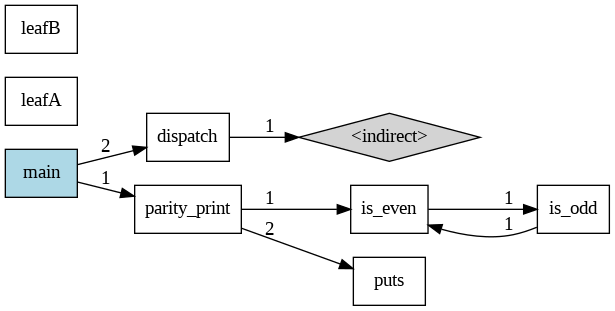

In [5]:
import pathlib, subprocess
pathlib.Path("cg.dot").write_text(dot)
subprocess.run(["dot", "-Tpng", "cg.dot", "-o", "cg.png"], check=True)

from PIL import Image
Image.open("cg.png")